<a href="https://colab.research.google.com/github/SwetaSengupta/DS-Unit-2-Kaggle-Challenge/blob/master/Copy_of_LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [14]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
#Split train into train and val
train,val = train_test_split(train, train_size = 0.80, test_size = 0.20,stratify=train['status_group'],random_state=45)

train.shape, val.shape,test.shape

((47520, 41), (11880, 41), (14358, 40))

In [3]:
# Check Pandas Profiling version
import matplotlib.pyplot as plt
import pandas_profiling
pandas_profiling.__version__

'2.5.0'

In [ ]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

##This is a multi-class classification problem. The majority class occurs with 54% frequency

In [ ]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

##Visualizing the data and checking for outliers

In [ ]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

##Inspecting the latitude and longitude data

In [ ]:



train[['longitude','latitude']].describe()

longitude      latitude
count  47520.000000  4.752000e+04
mean      34.075549 -5.714979e+00
std        6.569896  2.948341e+00
min        0.000000 -1.164944e+01
25%       33.084511 -8.548985e+00
50%       34.907466 -5.030529e+00
75%       37.183756 -3.329228e+00
max       40.345193 -2.000000e-08

##Fix the location, and do more data cleaning and feature engineering.

In [ ]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
  
    #creating column year 
    X['year'] = pd.DatetimeIndex(X['date_recorded']).year
    

    #creating a new new column years between inspection
    X['construction_year'] = X['construction_year'].replace(0, 2010)
    X['yrs_bw_insp'] = X['year'] - X['construction_year']                   
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns=['quantity_group' ])
    
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [32]:
train.head(10)

id  amount_tsh date_recorded  ...    status_group  year yrs_bw_insp
49821  22362        20.0    2011-03-07  ...      functional  2011           3
1158   59430         0.0    2011-07-29  ...  non functional  2011           1
34468  10886         0.0    2013-02-18  ...  non functional  2013          36
12617  15499       250.0    2013-01-19  ...  non functional  2013           4
36123  34760         0.0    2011-07-31  ...  non functional  2011           1
58244  37074         0.0    2011-07-27  ...      functional  2011           1
33432  39745         0.0    2012-10-16  ...  non functional  2012          37
36885  44427         0.0    2013-12-03  ...      functional  2013          15
10457  38815      1000.0    2011-02-24  ...  non functional  2011          11
1295    7897        70.0    2013-02-24  ...  non functional  2013          35

[10 rows x 42 columns]

In [31]:
train.lga.value_counts()


Njombe          2003
Moshi Rural      986
Arusha Rural     976
Bariadi          931
Kilosa           873
                ... 
Moshi Urban       63
Kigoma Urban      60
Arusha Urban      49
Lindi Urban       17
Nyamagana          1
Name: lga, Length: 125, dtype: int64

##Visualizing longititude, latitude with status_group without the outliers

In [ ]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

In [ ]:
# https://plot.ly/python/mapbox-layers/#base-maps-in-layoutmapboxstyle
fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

In [22]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'year', 'yrs_bw_insp', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [ ]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

###DecisionTreeClassifier

In [24]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


pipeline = make_pipeline(
       ce.OneHotEncoder(use_cat_names=True),
       SimpleImputer(strategy='median'),
       #StandardScaler(),
       DecisionTreeClassifier(random_state = 42, min_samples_leaf=5)
)


#fit on train
pipeline.fit(X_train,y_train)

#score on train

print('Train Accuracy', pipeline.score(X_train, y_train))

#score on val

print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8765361952861953
Validation Accuracy 0.7632996632996633


###Feature Selection using Decision Tree

In [20]:
pipeline.named_steps['decisiontreeclassifier'].feature_importances_

array([3.69861079e+00, 5.40586630e+00, 1.41229878e+01, 1.24138544e+01,
       5.96577902e-02, 1.22047488e+00, 2.31043655e+00, 3.26453296e+00,
       1.70625309e+00, 2.97740143e-01, 4.32209480e+00, 2.12189627e-02,
       6.15187836e-02, 2.01455127e-01, 5.29324854e-02, 1.71223786e-01,
       0.00000000e+00, 1.03361603e-01, 2.34683951e-01, 5.12956816e-01,
       5.29978754e-02, 5.15978416e-02, 1.55957179e-03, 2.04199766e-01,
       0.00000000e+00, 7.62677091e-02, 9.33483651e-03, 1.81783732e-02,
       0.00000000e+00, 5.21532898e-01, 6.73423647e-01, 0.00000000e+00,
       7.85251654e-04, 0.00000000e+00, 6.72364619e-02, 1.42728732e-01,
       1.01760643e-01, 1.34991924e-01, 9.24238260e-02, 1.20705724e-01,
       1.65363717e-02, 3.06420315e-01, 1.16453791e-01, 2.90956604e-01,
       0.00000000e+00, 1.90149584e-01, 1.03363410e-01, 9.54527487e-02,
       1.60156238e-01, 4.75965144e-02, 2.70509562e-02, 4.66506169e-01,
       1.36837079e-02, 3.39612391e-02, 2.52088238e-02, 2.93564933e-02,
      

##Stretch Goal
###  Plotting Feature Importances with Decison tree classifier

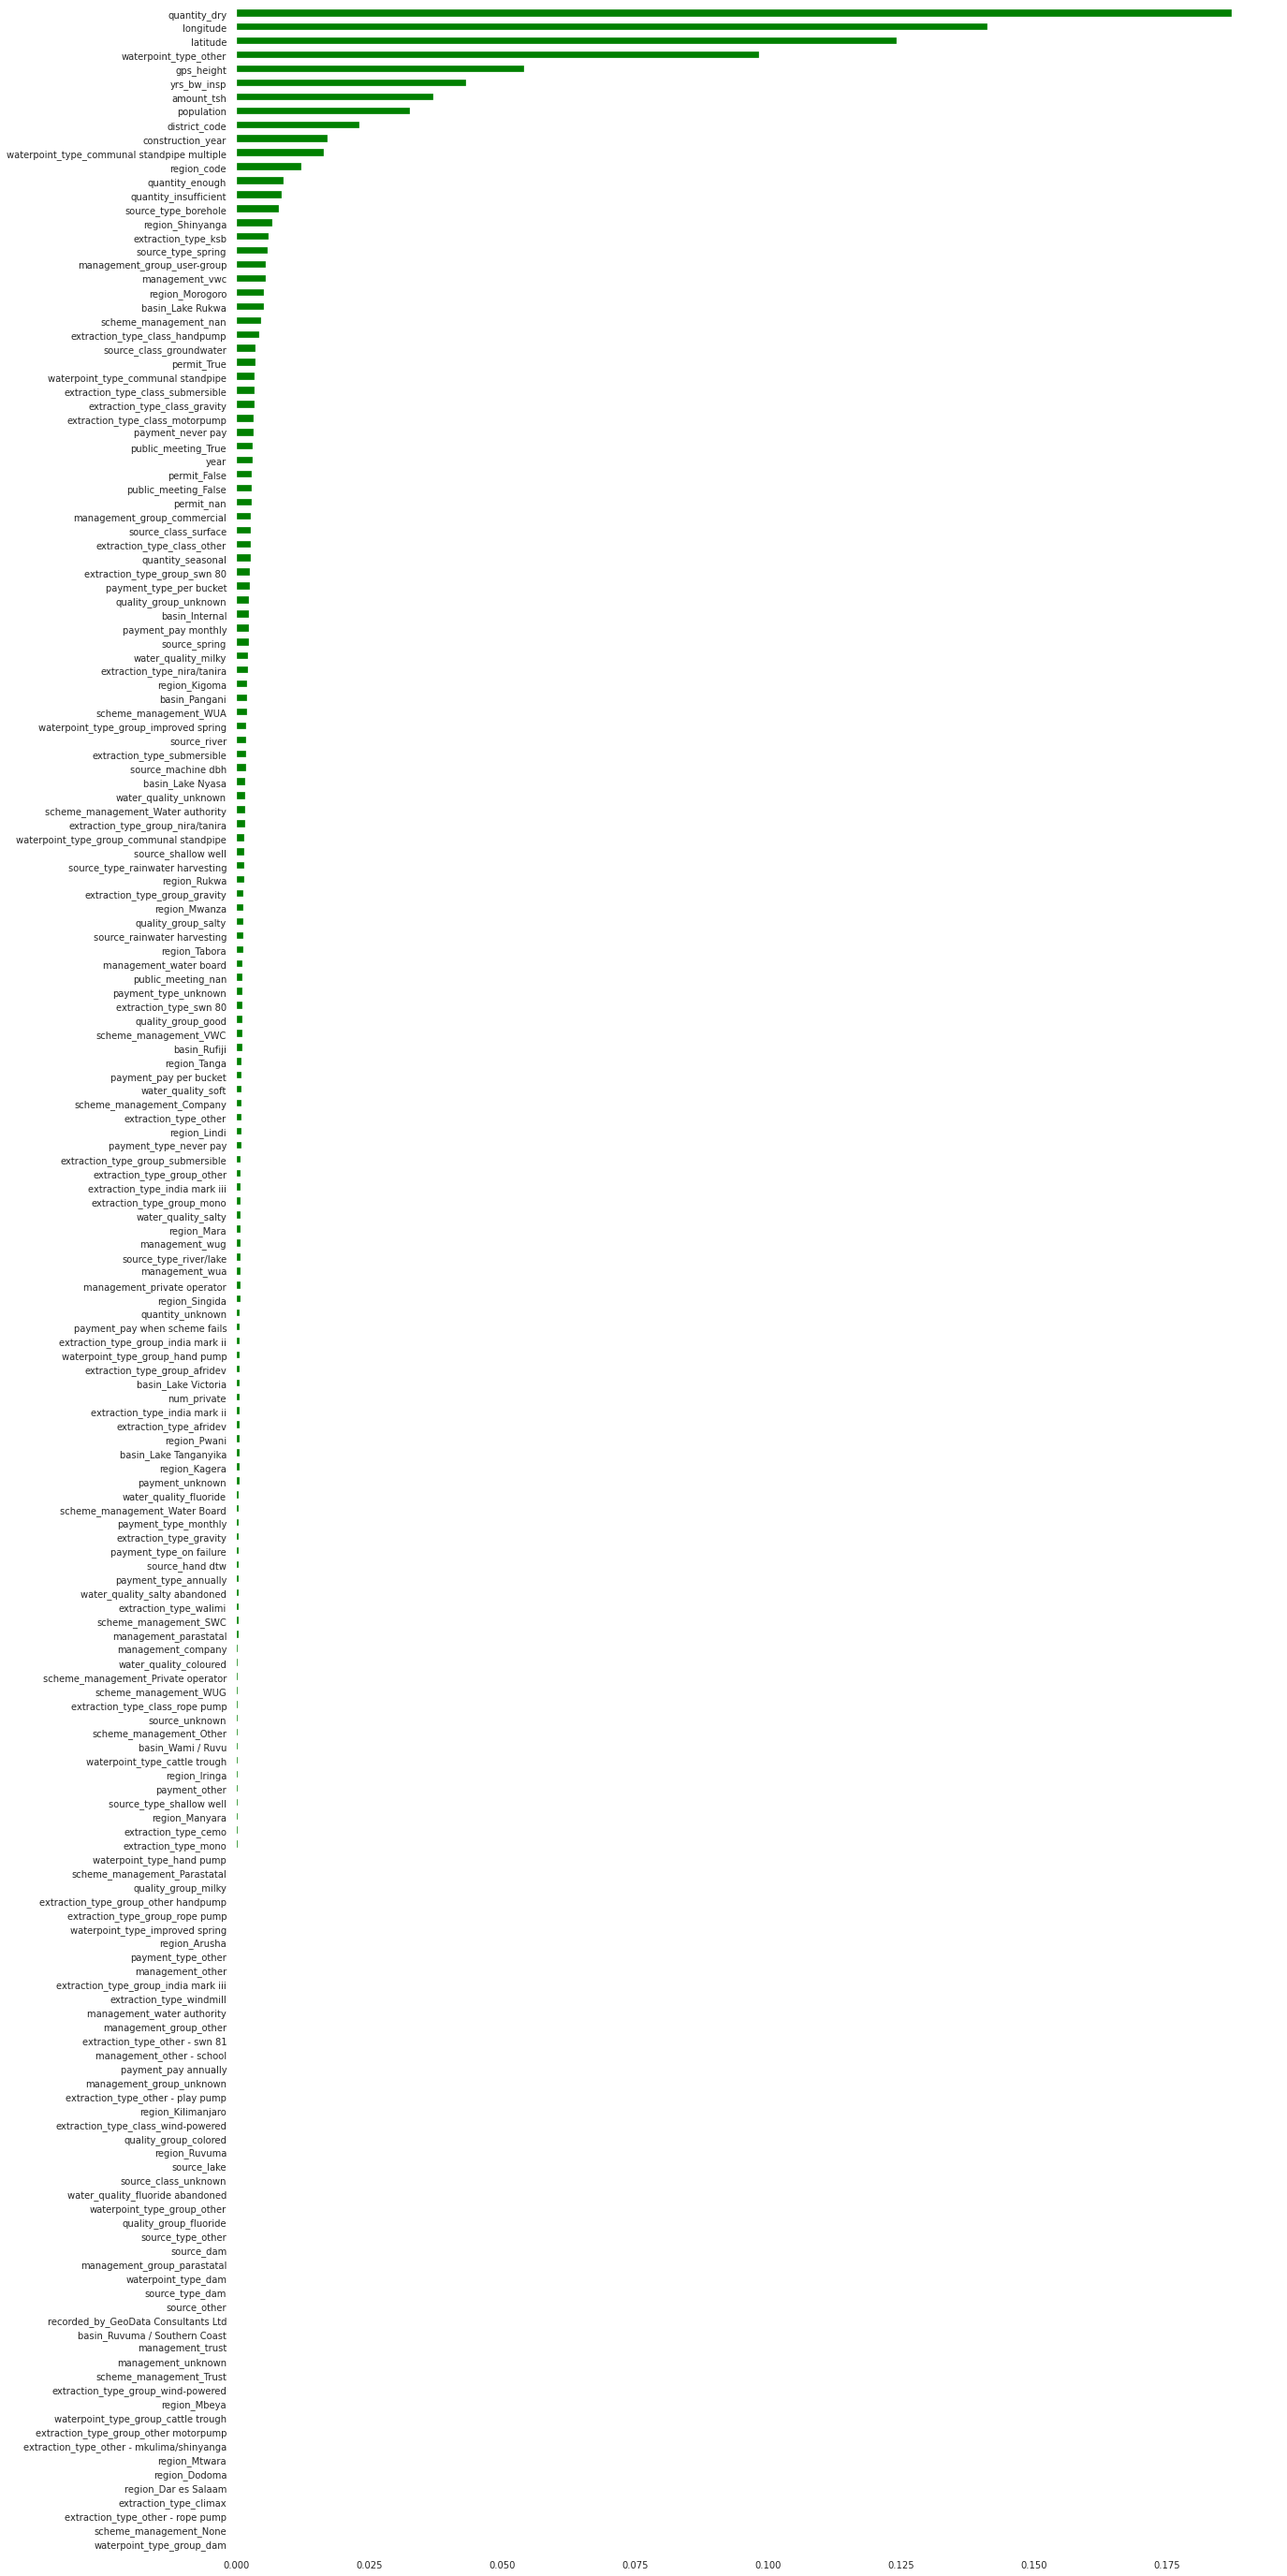

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
imp = pd.Series(model.feature_importances_,encoded_columns)
plt.figure(figsize=(20,50))
imp.sort_values().plot.barh(color='green')

In [26]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from numpy import set_printoptions
from sklearn.tree import DecisionTreeClassifier


encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)

dt = DecisionTreeClassifier(random_state = 42, min_samples_leaf=5)
dt.fit(X_train_scaled,y_train)

# Print the name and gini importance of each feature
for feature in zip(features, dt.feature_importances_*100):
    print(feature)


('amount_tsh', 3.6962313218532423)
('gps_height', 5.4156654784014195)
('longitude', 14.306812199792143)
('latitude', 12.268248162917251)
('num_private', 0.05934333815327179)
('region_code', 1.3563406848174289)
('district_code', 2.290655005497875)
('population', 3.282748495005365)
('construction_year', 1.6653796438119368)
('year', 0.1948888490796893)
('yrs_bw_insp', 4.442214829223096)
('basin', 0.04889260481938764)
('region', 0.02410065435044004)
('public_meeting', 0.21108257982170048)
('recorded_by', 0.04132022095016421)
('scheme_management', 0.16288164010271605)
('permit', 0.0)
('extraction_type', 0.04237766424555736)
('extraction_type_group', 0.2207986307146729)
('extraction_type_class', 0.5123382697609331)
('management', 0.05293396816966488)
('management_group', 0.08163831530654694)
('payment', 0.001557691192754747)
('payment_type', 0.20395353283574738)
('water_quality', 0.0)
('quality_group', 0.05595355795040949)
('quantity', 0.0)
('source', 0.07901575354851754)
('source_type', 0.0

###Feature Selection using Random Forest

In [13]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from numpy import set_printoptions
from sklearn.ensemble import RandomForestClassifier


encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()
X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)

rf =RandomForestClassifier(random_state = 42,n_estimators=90,max_depth=15,min_samples_leaf=2,n_jobs=-1)
rf.fit(X_train_scaled,y_train)

# Print the name and gini importance of each feature
for feature in zip(features, rf.feature_importances_*100):
    print(feature)


('amount_tsh', 2.5146180036368047)
('gps_height', 2.7998501536763176)
('longitude', 4.78658764466553)
('latitude', 4.472466711450574)
('num_private', 0.07067748391111948)
('region_code', 1.7394467917073042)
('district_code', 1.9490995780440556)
('population', 2.088795146745092)
('construction_year', 3.7601177141574107)
('year', 0.7120998536843499)
('yrs_bw_insp', 3.4453060580163486)
('basin', 0.22461776191024335)
('region', 0.3808737929477714)
('public_meeting', 0.2965190407543599)
('recorded_by', 0.2862358989679898)
('scheme_management', 0.3092334168991702)
('permit', 0.26977157859124473)
('extraction_type', 0.24715008381268389)
('extraction_type_group', 0.3594681794099911)
('extraction_type_class', 0.3531906453386944)
('management', 0.1373048003028973)
('management_group', 0.11173049587719576)
('payment', 0.2151092219784515)
('payment_type', 0.338509215935595)
('water_quality', 0.23310457264938766)
('quality_group', 0.1607054378021952)
('quantity', 0.18375996467216343)
('source', 0.7

###LogisticRegression

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


pipeline = make_pipeline(
       ce.OneHotEncoder(use_cat_names=True),
       SimpleImputer(strategy='mean'),
       StandardScaler(),
       LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
       )
#fit on train
pipeline.fit(X_train,y_train)

#score on train
#should have been only X_train
print('Train Accuracy', pipeline.score(X_train, y_train))

#score on val
#should have been only X_val
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.7402356902356902
Validation Accuracy 0.7352693602693603


#Feature Selection using Logistic Regression

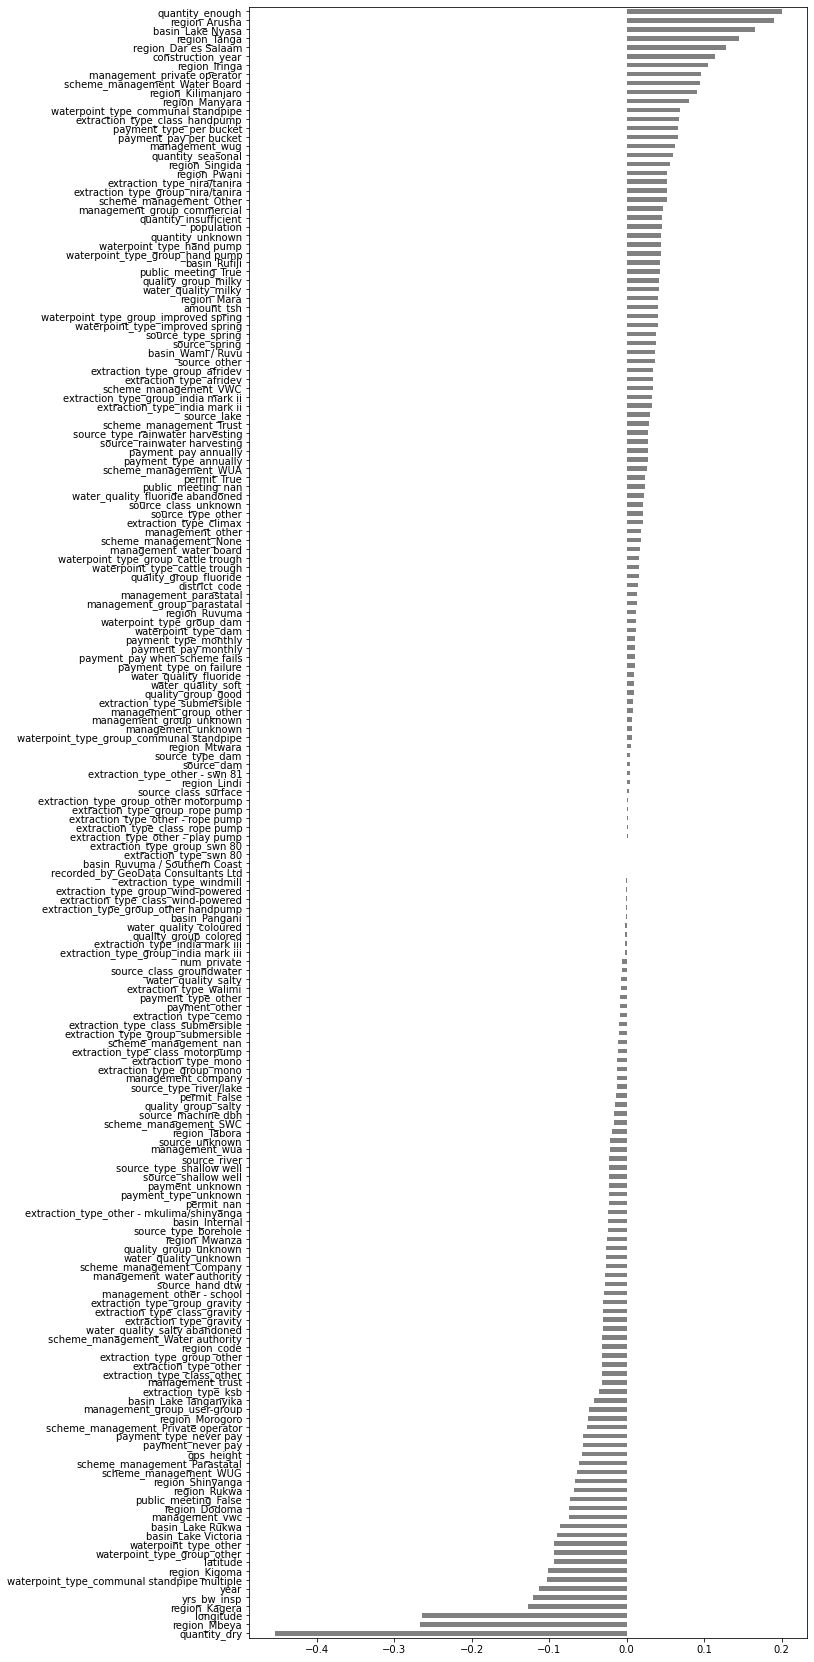

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

###RandomForestClassifier

In [36]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


pipeline = make_pipeline(
       ce.OneHotEncoder(use_cat_names=True),
       SimpleImputer(strategy='median'),
       #StandardScaler(),
      RandomForestClassifier(random_state = 42,n_estimators=90,max_depth=15,min_samples_leaf=2,n_jobs=-1)
)


#fit on train
pipeline.fit(X_train,y_train)

#score on train

print('Train Accuracy', pipeline.score(X_train, y_train))

#score on val

print('Validation Accuracy', pipeline.score(X_val, y_val))



Train Accuracy 0.814793771043771
Validation Accuracy 0.7845959595959596


###SVC-could not run

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


pipeline = make_pipeline(
       ce.OneHotEncoder(use_cat_names=True),
        SimpleImputer(strategy='mean'),
        #StandardScaler(),
        SVC(gamma='auto')
 )


# #fit on train
pipeline.fit(X_train,y_train)

# #score on train

print('Train Accuracy', pipeline.score(X_train, y_train))

# #score on val

print('Validation Accuracy', pipeline.score(X_val, y_val))

###KNeighborsClassifier

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier



pipeline = make_pipeline(
       ce.OneHotEncoder(use_cat_names=True),
       SimpleImputer(strategy='median'),
       StandardScaler(),
       KNeighborsClassifier(n_neighbors=9,n_jobs=-1,leaf_size=81)
      )


#fit on train
pipeline.fit(X_train,y_train)

#score on train

print('Train Accuracy', pipeline.score(X_train, y_train))

#score on val

print('Validation Accuracy', pipeline.score(X_val, y_val))



Train Accuracy 0.8058501683501683
Validation Accuracy 0.7612794612794613


###RidgeClassifierCV

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


pipeline = make_pipeline(
       ce.OneHotEncoder(use_cat_names=True),
       SimpleImputer(strategy='mean'),
       StandardScaler(),
       RidgeClassifierCV(alphas=[1])
      )

#fit on train
pipeline.fit(X_train,y_train)

#score on train
#should have been only X_train
print('Train Accuracy', pipeline.score(X_train, y_train))

#score on val
#should have been only X_val
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.7289562289562289
Validation Accuracy 0.7235690235690235


##Voting Classifier

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn. ensemble import  VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()

lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state = 42,min_samples_leaf=10, max_depth=15)
rf = RandomForestClassifier(random_state = 42,n_estimators=90,max_depth=15,min_samples_leaf=2,n_jobs=-1)
evc = VotingClassifier( estimators= [('lr',lr),('dt',dt),('rf',rf)], voting = 'soft')

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)

evc.fit(X_train_scaled, y_train)

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)
print('Train Accuracy',evc.score(X_train_scaled,y_train))
print('Validation Accuracy', evc.score(X_val_scaled, y_val))

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
#y_pred = model.predict(X_test_scaled)

ERROR! Session/line number was not unique in database. History logging moved to new session 64
Train Accuracy 0.8050084175084176
Validation Accuracy 0.7741582491582492


###Voting Classifier

In [37]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn. ensemble import  VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()


xb = xgb.XGBClassifier(random_state=42,max_depth=10,learning_rate=0.1,colsample_bytree=0.9,n_estimators=90,n_jobs=-1)
gb = GradientBoostingClassifier(random_state=42, max_depth=9,n_estimators=100,min_samples_leaf=7)
rf = RandomForestClassifier(random_state = 42,n_estimators=90,max_depth=15,min_samples_leaf=2,n_jobs=-1)
evc = VotingClassifier( estimators= [('xb',xb),('gb',gb),('rf',rf)], voting = 'soft')

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)

evc.fit(X_train_scaled, y_train)

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)
print('Train Accuracy',evc.score(X_train_scaled,y_train))
print('Validation Accuracy', evc.score(X_val_scaled, y_val))

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
#y_pred = model.predict(X_test_scaled)

Train Accuracy 0.8517045454545454
Validation Accuracy 0.801936026936027


###ExtraTreesClassifier

In [ ]:

from sklearn.ensemble import ExtraTreesClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(
       ce.OneHotEncoder(use_cat_names=True),
       SimpleImputer(strategy='mean'),
       StandardScaler(),
       ExtraTreesClassifier(random_state=42, max_depth=20,n_estimators=90,min_samples_leaf=2)
      )

#fit on train
pipeline.fit(X_train,y_train)

#score on train
#should have been only X_train
print('Train Accuracy', pipeline.score(X_train, y_train))

#score on val
#should have been only X_val
print('Validation Accuracy', pipeline.score(X_val, y_val))



Train Accuracy 0.8241792929292929
Validation Accuracy 0.7870370370370371


###Voting Classifier

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn. ensemble import  VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = StandardScaler()

et = ExtraTreesClassifier(random_state = 42,min_samples_leaf=10, max_depth=15,n_estimators=90)
rf = RandomForestClassifier(random_state = 42,n_estimators=90,max_depth=15,min_samples_leaf=2,n_jobs=-1)
evc = VotingClassifier( estimators= [('et',et),('rf',rf)], voting = 'soft')

X_train_encoded = encoder.fit_transform(X_train)
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_train_scaled = scaler.fit_transform(X_train_imputed)

evc.fit(X_train_scaled, y_train)

X_val_encoded = encoder.transform(X_val)
X_val_imputed = imputer.transform(X_val_encoded)
X_val_scaled = scaler.transform(X_val_imputed)
print('Train Accuracy',evc.score(X_train_scaled,y_train))
print('Validation Accuracy', evc.score(X_val_scaled, y_val))

X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
#y_pred = model.predict(X_test_scaled)

Train Accuracy 0.8001893939393939
Validation Accuracy 0.7766835016835016


###GradientBoostingClassifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(
       ce.OneHotEncoder(use_cat_names=True),
       SimpleImputer(strategy='mean'),
       StandardScaler(),
       GradientBoostingClassifier(random_state=42,n_estimators=100,min_samples_leaf=7, max_depth=9)
      )

#fit on train
pipeline.fit(X_train,y_train)

#score on train
#should have been only X_train
print('Train Accuracy', pipeline.score(X_train, y_train))

#score on val
#should have been only X_val
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.866813973063973
Validation Accuracy 0.8044612794612794


###AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(
       ce.OneHotEncoder(use_cat_names=True),
       SimpleImputer(strategy='mean'),
       StandardScaler(),
      AdaBoostClassifier (DecisionTreeClassifier(max_depth=9), n_estimators=60,learning_rate=1)
      )

#fit on train
pipeline.fit(X_train,y_train)

#score on train
#should have been only X_train
print('Train Accuracy', pipeline.score(X_train, y_train))

#score on val
#should have been only X_val
print('Validation Accuracy', pipeline.score(X_val, y_val))


Train Accuracy 0.8978956228956229
Validation Accuracy 0.725


###XGBClassifier

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


pipeline = make_pipeline(
       ce.OneHotEncoder(use_cat_names=True),
       SimpleImputer(strategy='mean'),
       StandardScaler(),
       xgb.XGBClassifier(random_state=42,max_depth=10,learning_rate=0.1,colsample_bytree=0.9,n_estimators=90,n_jobs=-1)
      )

#fit on train
pipeline.fit(X_train,y_train)

#score on train
#should have been only X_train
print('Train Accuracy', pipeline.score(X_train, y_train))

#score on val
#should have been only X_val
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8576388888888888
Validation Accuracy 0.8007575757575758
